In [9]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set up project root path
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(ROOT_PATH)

from Models.LSTM import LSTMModel
from Training.Helper.dataPreprocessing import (
    create_sequences, prepare_dataloader,
    rank_features_ccf, make_stationary, granger_causes
)
from Training.Helper.PyTorchModular import loss_curve, optuna_tune_and_train
from Training.Helper.hyperparameters import load_best_hyperparameters

train_file = os.path.join(ROOT_PATH, "Data", "Train", "train1990s.csv")
model_save_path = os.path.join(ROOT_PATH, "Models", "Weights", "LSTM")
model_name = "LSTM"
sequence_length = 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# --- Load and Filter Data ---
df = pd.read_csv(train_file, parse_dates=[0], index_col=0)
target_col = "fred_PCEPI"
dropCols = []

for col in df.columns.drop(target_col):
    stationary = make_stationary(df, col, target_col)
    if stationary is np.nan or not granger_causes(df, col, target_col):
        dropCols.append(col)

caused_df = df.drop(columns=dropCols)
ranked_columns = np.delete(rank_features_ccf(caused_df, target_col), [4])  # remove target if present


/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/ipykernel_2966/3206660112.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(train_file, parse_dates=[0], index_col=0)
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWar

In [ ]:
# --- Run Optimal Feature Search ---
def find_optimal_exog_count_lstm(df, target_col, ranked_columns, top_n, sequence_length, device):
    target = df[target_col].values
    scaler = MinMaxScaler()
    scaled_target = scaler.fit_transform(target.reshape(-1, 1)).flatten()

    results = []

    for i in range(1, top_n + 1):
        exog_subset = df[ranked_columns[:i]].values

        X_seq, X_exog, y_seq = create_sequences(
            data=scaled_target,
            target=scaled_target,
            seq_len=sequence_length,
            exog=exog_subset,
            config={"use_exog": True}
        )

        X_exog_seq = np.repeat(X_exog[:, np.newaxis, :], sequence_length, axis=1)
        X_combined = np.concatenate([X_seq[:, :, np.newaxis], X_exog_seq], axis=2)

        n = len(X_combined)
        valid_idx = int(n * 0.8)
        X_train, X_val = X_combined[:valid_idx], X_combined[valid_idx:]
        y_train, y_val = y_seq[:valid_idx], y_seq[valid_idx:]

        train_loader = prepare_dataloader(X_train, y_train, shuffle=False)
        val_loader = prepare_dataloader(X_val, y_val, shuffle=False)

        model = LSTMModel(input_size=X_combined.shape[-1], hidden_size=32, num_layers=1, output_size=1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        for epoch in range(10):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb).squeeze(), yb)
                loss.backward()
                optimizer.step()

        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                preds.append(model(xb.to(device)).squeeze().cpu().numpy())
                targets.append(yb.numpy())

        preds = np.concatenate(preds)
        targets = np.concatenate(targets)
        rmse = np.sqrt(mean_squared_error(targets, preds))
        results.append((i, rmse))
        print(f"Top {i} features -> RMSE: {rmse:.4f}")

    return results

top_n = 150
results = find_optimal_exog_count_lstm(caused_df, target_col, ranked_columns, top_n, sequence_length, device)
best_n = min(results, key=lambda x: x[1])[0]
print(f"\n Optimal number of exogenous features: {best_n}")

Top 1 features -> RMSE: 0.3810
Top 2 features -> RMSE: 0.3994
Top 3 features -> RMSE: 0.4046
Top 4 features -> RMSE: 0.4127
Top 5 features -> RMSE: 0.4108
Top 6 features -> RMSE: 0.3254
Top 7 features -> RMSE: 0.3317
Top 8 features -> RMSE: 0.3979
Top 9 features -> RMSE: 0.3041
Top 10 features -> RMSE: 0.3299
Top 11 features -> RMSE: 0.4248
Top 12 features -> RMSE: 0.3408
Top 13 features -> RMSE: 0.3540
Top 14 features -> RMSE: 0.3068
Top 15 features -> RMSE: 0.4598
Top 16 features -> RMSE: 0.4063
Top 17 features -> RMSE: 0.3683
Top 18 features -> RMSE: 0.3820
Top 19 features -> RMSE: 0.3816
Top 20 features -> RMSE: 0.3749
Top 21 features -> RMSE: 0.3201
Top 22 features -> RMSE: 0.4167
Top 23 features -> RMSE: 0.2729
Top 24 features -> RMSE: 0.4268
Top 25 features -> RMSE: 0.4248
Top 26 features -> RMSE: 0.4285
Top 27 features -> RMSE: 0.4589
Top 28 features -> RMSE: 0.7364
Top 29 features -> RMSE: 0.5371
Top 30 features -> RMSE: 0.4315
Top 31 features -> RMSE: 0.4965
Top 32 features -

In [ ]:
# --- Use best_n exogenous features for full LSTM training ---
scaler = MinMaxScaler()
scaled_target = scaler.fit_transform(df[target_col].values.reshape(-1, 1)).flatten()
final_exog = caused_df[ranked_columns[:best_n]].values

# Create training/validation split with 1-step overlap before validation
n_total = len(scaled_target)
n_train = int(n_total * 0.8)
train_input_start = 0
train_input_end = n_train
val_input_start = n_train - sequence_length
val_input_end = n_total

X_seq_train, X_exog_train, y_train = create_sequences(
    data=scaled_target[train_input_start:train_input_end],
    target=scaled_target[train_input_start:train_input_end],
    seq_len=sequence_length,
    exog=final_exog[train_input_start:train_input_end],
    config={"use_exog": True}
)

X_seq_val, X_exog_val, y_val = create_sequences(
    data=scaled_target[val_input_start:val_input_end],
    target=scaled_target[val_input_start:val_input_end],
    seq_len=sequence_length,
    exog=final_exog[val_input_start:val_input_end],
    config={"use_exog": True}
)

X_combined_train = np.concatenate([X_seq_train[:, :, np.newaxis], np.repeat(X_exog_train[:, np.newaxis, :], sequence_length, axis=1)], axis=2)
X_combined_val = np.concatenate([X_seq_val[:, :, np.newaxis], np.repeat(X_exog_val[:, np.newaxis, :], sequence_length, axis=1)], axis=2)

train_loader = prepare_dataloader(X_combined_train, y_train)
val_loader = prepare_dataloader(X_combined_val, y_val)


[I 2025-04-01 15:05:32,782] A new study created in memory with name: LSTM_hyperparameter_optimisation


 Running Optuna hyperparameter tuning...


/Users/natalieleung/miniforge3/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-04-01 15:05:38,605] Trial 0 finished with value: 0.028206110416020422 and parameters: {'hidden_size': 73, 'num_layers': 4, 'lr': 0.003015949621075836}. Best is trial 0 with value: 0.028206110416020422.
[I 2025-04-01 15:05:40,167] Trial 1 finished with value: 0.0

 Best hyperparameters found: {'hidden_size': 88, 'num_layers': 1, 'lr': 0.0006141855553458956}


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/natalieleung/miniforge3/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50 - Train Loss: 0.250246, Val Loss: 0.471746
Best model saved at /Users/natalieleung/Desktop/COMP5530M-Group-Project-Inflation-Forecasting/Models/Weights/LSTM/LSTM_BEST_STOPPED_AT_1.pth (Epoch 1)
Epoch 2/50 - Train Loss: 0.045765, Val Loss: 0.140220
Best model saved at /Users/natalieleung/Desktop/COMP5530M-Group-Project-Inflation-Forecasting/Models/Weights/LSTM/LSTM_BEST_STOPPED_AT_2.pth (Epoch 2)
Epoch 3/50 - Train Loss: 0.035895, Val Loss: 0.181042
Epoch 4/50 - Train Loss: 0.028978, Val Loss: 0.205461
Epoch 5/50 - Train Loss: 0.028209, Val Loss: 0.174171
Epoch 6/50 - Train Loss: 0.028376, Val Loss: 0.175744
Epoch 7/50 - Train Loss: 0.028078, Val Loss: 0.189818
Epoch 8/50 - Train Loss: 0.028109, Val Loss: 0.174623
Epoch 9/50 - Train Loss: 0.028054, Val Loss: 0.177259
Epoch 10/50 - Train Loss: 0.028020, Val Loss: 0.179207
Epoch 11/50 - Train Loss: 0.028038, Val Loss: 0.177032
Epoch 12/50 - Train Loss: 0.028177, Val Loss: 0.177300
Epoch 13/50 - Train Loss: 0.028015, Val Loss: 0

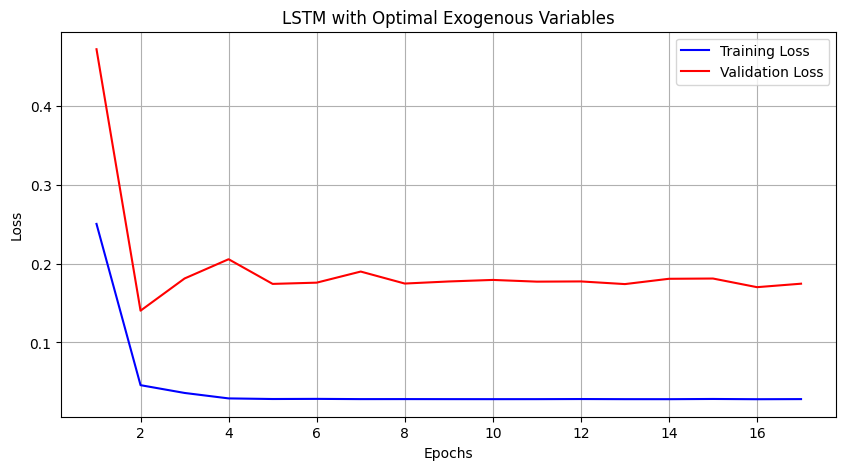


 Model weights saved to: /Users/natalieleung/Desktop/COMP5530M-Group-Project-Inflation-Forecasting/Models/Weights/LSTM/LSTM.pt


In [ ]:
# --- Optuna-compatible model wrapper ---
actual_input_size = X_combined_train.shape[-1]

class WrappedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.model = LSTMModel(
            input_size=actual_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=output_size
        )

    def forward(self, x):
        return self.model(x)

model, metadata = optuna_tune_and_train(
    model_class=WrappedLSTMModel,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    max_epochs=50,
    model_save_path=model_save_path,
    model_name=model_name,
    use_best_hyperparams=False,
    n_trials=20,
    verbose=True
)

loss_curve(metadata["trainLoss"], metadata["validLoss"], title="LSTM with Optimal Exogenous Variables")

# --- Save final model weights ---
weights_path = os.path.join(model_save_path, f"{model_name}.pth")
torch.save(model.state_dict(), weights_path)
print(f"\n Model weights saved to: {weights_path}")



 Forecast saved to: /Users/natalieleung/Desktop/COMP5530M-Group-Project-Inflation-Forecasting/Predictions/LSTM.npy


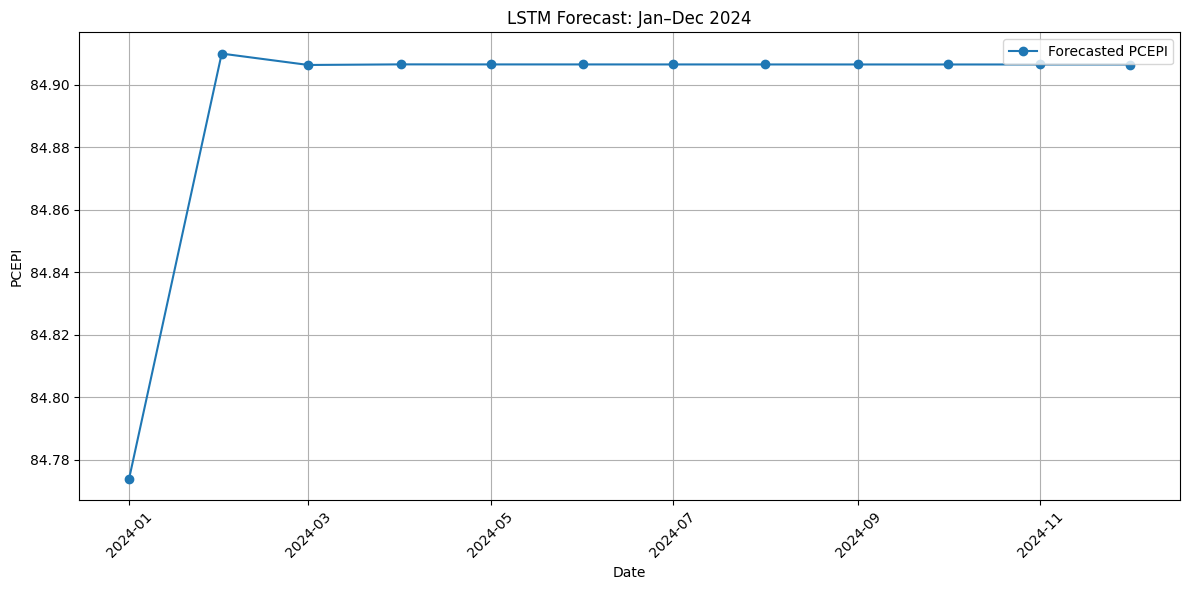

In [ ]:
# --- Forecast Jan–Dec 2024 ---
input_seq = scaled_target[-sequence_length:]
exog_input = final_exog[-1, :best_n]

future_preds = []
model.eval()
for _ in range(12):
    exog_seq = np.tile(exog_input, (sequence_length, 1))
    seq_input = input_seq.reshape(sequence_length, 1)
    combined_input = np.concatenate([seq_input, exog_seq], axis=1)
    input_tensor = torch.tensor(combined_input[np.newaxis], dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_scaled = model(input_tensor).cpu().numpy().flatten()[0]
    pred_actual = scaler.inverse_transform([[pred_scaled]])[0, 0]
    future_preds.append(pred_actual)
    input_seq = np.append(input_seq[1:], pred_scaled)

forecast_dates = pd.date_range(start="2024-01-01", periods=12, freq='MS')
future_preds = np.array(future_preds)

# --- Save predictions ---
pred_path = os.path.join(ROOT_PATH, "Predictions", "LSTM.npy")
np.save(pred_path, future_preds)
print(f"\n Forecast saved to: {pred_path}")

plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, future_preds, marker='o', linestyle='-', label="Forecasted PCEPI")
plt.title("LSTM Forecast: Jan–Dec 2024")
plt.xlabel("Date")
plt.ylabel("PCEPI")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
